In [75]:
# Importing packages

from astropy.io import fits # For handling fits files
from astropy.wcs import WCS # Applying coordinates to images
from glob import glob # to search for file paths under similar names

import numpy as np
from matplotlib import pyplot as plt
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 26})
plt.rcParams["figure.figsize"] = (12,12)

from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

# Importing all data

In [2]:
rootPath = r"/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis"

## M91

In [3]:
# Note each group of files is a list for each band

# Bias
biasFiles_M91 = [glob(rootPath + r"/data_2019/M91/bias/*.fits")]

# Flats
flatsFiles_M91 = [
    glob(rootPath + r"/data_2019/M91/flats/B/*.fits"),
    glob(rootPath + r"/data_2019/M91/flats/V/*.fits"),
    glob(rootPath + r"/data_2019/M91/flats/Halpha_NII/*.fits")
]

# Object
objectFiles_M91 = [
    glob(rootPath + r"/data_2019/M91/object/B/*.fits"),
    glob(rootPath + r"/data_2019/M91/object/V/*.fits"),
    glob(rootPath + r"/data_2019/M91/object/Halpha_NII/*.fits")
]

In [6]:
# Load files using astropy.fits

biasFITS_M91 = [fits.open(el) for el in biasFiles_M91[0]]

flatFITS_M91 = [[fits.open(el) for el in flatsFiles_M91[0]], \
                [fits.open(el) for el in flatsFiles_M91[1]], \
                [fits.open(el) for el in flatsFiles_M91[2]]]

objectFITS_M91 = [[fits.open(el) for el in objectFiles_M91[0]], \
                [fits.open(el) for el in objectFiles_M91[1]], \
                [fits.open(el) for el in objectFiles_M91[2]]]

## NNSer

In [7]:
# Note, only frames of NNSer in the clear band.

# Bias
biasFiles_NNSer = [glob(rootPath + r"/data_2019/NNSer/bias/*.fits")]

# Flats
flatsFiles_NNSer = [glob(rootPath + r"/data_2019/NNSer/flats/clear/*.fits")]

# Object
objectFiles_NNSer = [glob(rootPath + r"/data_2019/NNSer/object/clear/*.fits")]

In [8]:
biasFITS_NNSer = [fits.open(el) for el in biasFiles_NNSer[0]]

flatFITS_NNSer = [fits.open(el) for el in flatsFiles_NNSer[0]]

objectFITS_NNSer = [fits.open(el) for el in objectFiles_NNSer[0]]

# Data Reduction

## Create Master Bias and Flat files

In [9]:
# Read in the pixel values of each bias into an np array. 
# Find the average value of each pixel across all bias frames. 
# Assign each average pixel to a new file: masterBias.fits


# Takes a list of arrays and returns an array with each element being
# the average element of the list
def createAvgArray(arraysList):
    
    arraySum = np.empty(np.shape(arraysList[0]))
    
    for array in arraysList:
        arraySum += array

    return arraySum / len(arraysList)

# Converts a list of fits files into a list of arrays and passes it to the createAvgArray
# function to get the masterBias
def createMasterBias(biasList):
    
    arraysList = list()
    
    for el in biasList:
        arraysList.append(el[0].data)
    
    avg = createAvgArray(arraysList)

    return avg

# Converts a list of fits files into a list of arrays, subtacting the masterBias,
# and passes it to the createAvgArray function to get the masterFlat
def createMasterFlat(flatsList, masterBias):
    
    arraysList = list()
    
    for el in flatsList:
        arraysList.append(el[0].data - masterBias)
    
    avgArray = createAvgArray(arraysList)
    
    # normalisation, find the value at the centre and divide by it
    xLength, yLength = np.shape(avgArray)
    
    normFac = avgArray[int(xLength/2)][int(yLength/2)]

    return avgArray / normFac

In [10]:
masterBias_M91 = createMasterBias(biasFITS_M91)
masterBias_NNSer = createMasterBias(biasFITS_NNSer)

In [11]:
masterFlats_M91_B = createMasterFlat(flatFITS_M91[0], masterBias_M91)
masterFlats_M91_V = createMasterFlat(flatFITS_M91[1], masterBias_M91)
masterFlats_M91_Ha = createMasterFlat(flatFITS_M91[2], masterBias_M91)

# masterFlats_M91 is a list of 3 master flats, one for each band.
masterFlats_M91 = [masterFlats_M91_B, masterFlats_M91_V, masterFlats_M91_Ha]

masterFlat_NNSer = createMasterFlat(flatFITS_NNSer, masterBias_NNSer)

In [12]:
def writeFITS(array, newPath):
    hdu = fits.PrimaryHDU(array)
    hdu.writeto(newPath, overwrite=True)
    print(f"FITS image saved to: {newPath}")

In [13]:
writeFITS(masterBias_M91, rootPath + r"/output/masterFiles/masterBias_M91.fits")
writeFITS(masterBias_NNSer, rootPath + r"/output/masterFiles/masterBias_NNSer.fits")

writeFITS(masterFlats_M91_B, rootPath + r"/output/masterFiles/masterFlat_M91_B.fits")
writeFITS(masterFlats_M91_V, rootPath + r"/output/masterFiles/masterFlat_M91_V.fits")
writeFITS(masterFlats_M91_Ha, rootPath + r"/output/masterFiles/masterFlat_M91_Ha.fits")

writeFITS(masterFlat_NNSer, rootPath + r"/output/masterFiles/masterFlat_NNSer.fits")

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterBias_M91.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterBias_NNSer.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_B.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_V.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_Ha.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_NNSer.fits


## Reduce Images

In [14]:
def reduceImage(fitsFile, masterBias, masterFlat, newPath):
    # Reduces the image by subtracting the masterBias file and dividing by the masterFlat.
    # Note that the first 50 pixels are deleted. This is due to the bias = the flat and hence they observe no light
    
    fitsFile = np.delete(fitsFile[0].data, np.arange(0, 50, 1), 1)
    masterBias = np.delete(masterBias[0].data, np.arange(0, 50, 1), 1)
    masterFlat = np.delete(masterFlat[0].data, np.arange(0, 50, 1), 1)
    
    fileArray = fitsFile
    
    np.subtract(fileArray, masterBias)
    fileArray = fileArray / masterFlat
    
    writeFITS(fileArray, newPath)

### M91

In [15]:
# B Band
count=1
for el in objectFITS_M91[0]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_B.fits"), \
                        rootPath+f"/output/M91/B/M91_B_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_03.fits


In [16]:
# V Band
count=1
for el in objectFITS_M91[1]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_V.fits"), \
                        rootPath+f"/output/M91/V/M91_V_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_03.fits


In [17]:
# Halpha Band
count=1
for el in objectFITS_M91[2]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_Ha.fits"), \
                        rootPath+f"/output/M91/Halpha/M91_Ha_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/Halpha/M91_Ha_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/Halpha/M91_Ha_02.fits


### NNSer

In [18]:
# Clear Band
count=1
for el in objectFITS_NNSer:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_NNSer.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_NNSer.fits"), \
                        rootPath+f"/output/NNSer/clear/NNSer_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_03.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_04.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_05.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_06.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_07.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_08.fits
FITS image saved to: /home/darag

# Combining Bands

In [19]:
# We combine the bands for each set of images.

def combineBands(fitsList, newPath):
    # takes a list of fits files as an input and outputs a single fits file    
    
    arraysList = list()
    
    for el in fitsList:
        arraysList.append(el[0].data)
    
    avgArray = createAvgArray(arraysList)
    
    writeFITS(avgArray, newPath)

In [21]:
M91_combinedList = [fits.open(rootPath + r"/output/M91/B/M91_B_01.fits"), \
                   fits.open(rootPath + r"/output/M91/V/M91_V_01.fits"), \
                   fits.open(rootPath + r"/output/M91/Halpha/M91_Ha_01.fits")]

combineBands(M91_combinedList, rootPath + r"/output/M91/M91_combined_01.fits")

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/M91_combined_01.fits


# Measurement of Angular Size of M91

In [24]:
testArray = np.array([[5, 1, 3], [8, 4, 1], [4, 1, 1]])
print(testArray)
print(averagePixelCount(testArray))

[[5 1 3]
 [8 4 1]
 [4 1 1]]
3.111111111111111


In [4]:
def averagePixelCount(array):
    areaCounts=0
    divisor=0
    for line in array:
        for el in line:
            areaCounts += el
            divisor+=1
    return areaCounts / divisor    

def angularSize(fits, bucketSize, tol, vMin, vMax, showPlot=False):
    # Function takes fits file as input, plots image with plt.imshow with the angular sizes displayed and returned
    # Returns angular size in arcseconds
    image = fits[0].data
    
    backgroundAvg = averagePixelCount(image[0:250][:,500:750])
    print(backgroundAvg)
    
    # Find Y
    sequence = 0
    angularSizeY = 0
    i=0
    while i < len(image[:,0]):
        j=0
        while j < len(image[0]):
            
            smallAreaAvg = averagePixelCount(image[i:i+bucketSize][:,j:j+bucketSize])
            
            if smallAreaAvg -tol > backgroundAvg:
                sequence += 1
            else:
                if sequence > angularSizeY:angularSizeY = sequence
                sequence = 0
            
            j+=bucketSize
        i+=bucketSize
        
    # Find X
    sequence = 0
    angularSizeX = 0
    i=0
    while i < len(image[0]):
        j=0
        while j < len(image[:,0]):
            
            smallAreaAvg = averagePixelCount(image[:,i:i+bucketSize][j:j+bucketSize])
            
            if smallAreaAvg -tol > backgroundAvg:
                sequence += 1
            else:
                if sequence > angularSizeX:
                    angularSizeX = sequence
                sequence = 0
            
            j+=bucketSize
        i+=bucketSize
    
    # Convert to pixels: * bucketSize
    angularSizeX *= bucketSize
    angularSizeY *= bucketSize
    print(f"Angular Size X: {angularSizeX} pixels, {angularSizeX*0.304} arcseconds")
    print(f"Angular Size Y: {angularSizeY} pixels, {angularSizeY*0.304} arcseconds")
    
    if showPlot:
        plt.imshow(image, vmin=vMin, vmax=vMax, cmap="Greys_r")
        plt.colorbar()
        
        centre = [1015, 850]
        t = np.linspace(0, 2*np.pi, 100)
        plt.plot( centre[0]+angularSizeX*np.cos(t) , centre[1]+angularSizeY*np.sin(t), color="grey")
        #plt.scatter(centre[0], centre[1])
        
    return [angularSizeX*0.304, angularSizeY*0.304]

565.4264461850552
Angular Size X: 615 pixels, 186.96 arcseconds
Angular Size Y: 635 pixels, 193.04 arcseconds


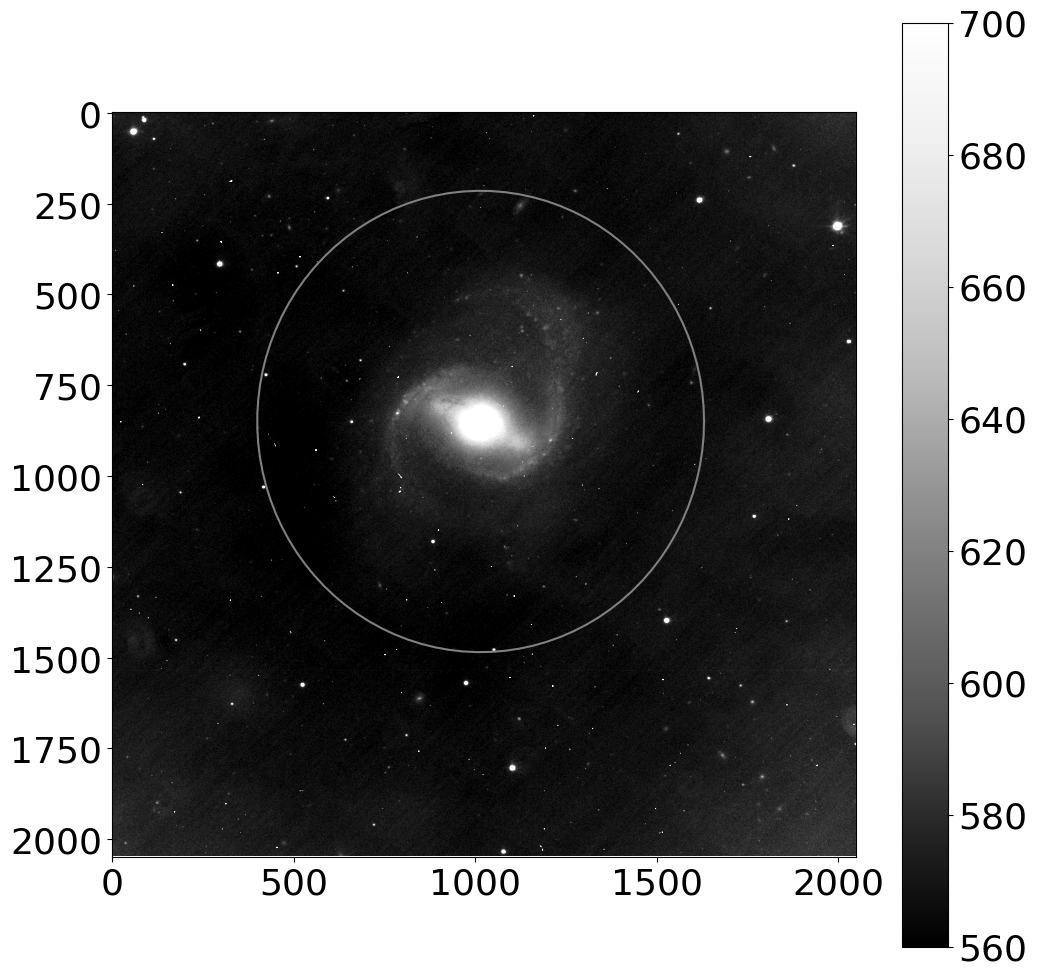

In [78]:
angSize = angularSize(fits.open(rootPath + r"/output/M91/M91_combined_01.fits"), 5, tol=10, showPlot=True, vMin=560, vMax=700)

In [22]:
def apparentSize(angSize, dist):
    return angSize / 206265 * dist # by the small angle approximation, 206265 arcseconds in a radian

print(f"M91 Diameter X: {apparentSize(angSize[0], 15000)} kpc")
print(f"M91 Diameter Y: {apparentSize(angSize[1], 15000)} kpc")

M91 Diameter X: 13.596102101665334 kpc
M91 Diameter Y: 14.038251763508107 kpc


In [ ]:
# Adjust for inclination and position angle

# NNSer

## Plot Lightcurve

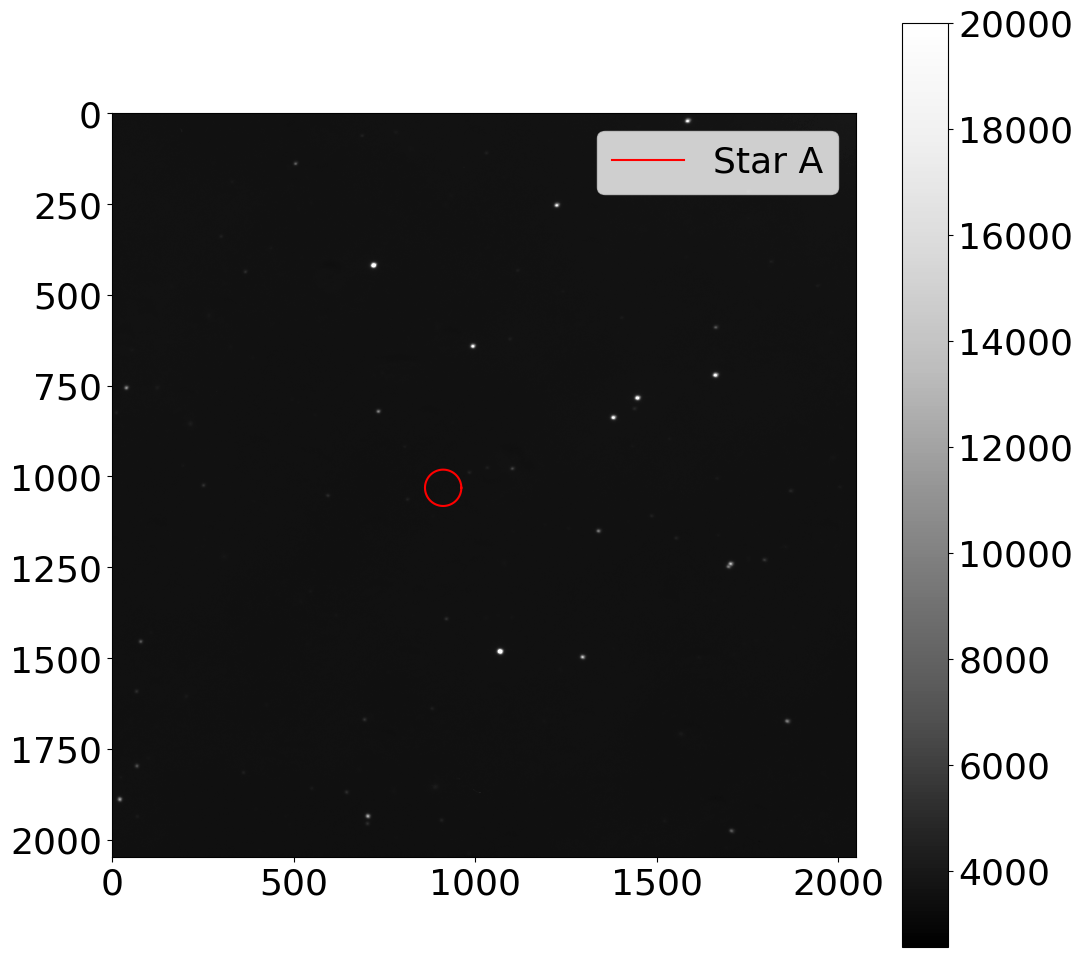

In [85]:
nnserIm = fits.open(rootPath + r"/output/NNSer/clear/NNSer_01.fits")[0].data

starA = [1024 -34.1 / 0.304, 1024 + 2.2 / 0.304]

t = np.linspace(0, 2*np.pi, 100)
radius = 50
plt.plot(starA[0]+ radius*np.cos(t) , starA[1]+ radius*np.sin(t), color="red", label="Star A")

plt.imshow(nnserIm, cmap="Greys_r", vmax="0000")
plt.colorbar()
plt.legend()

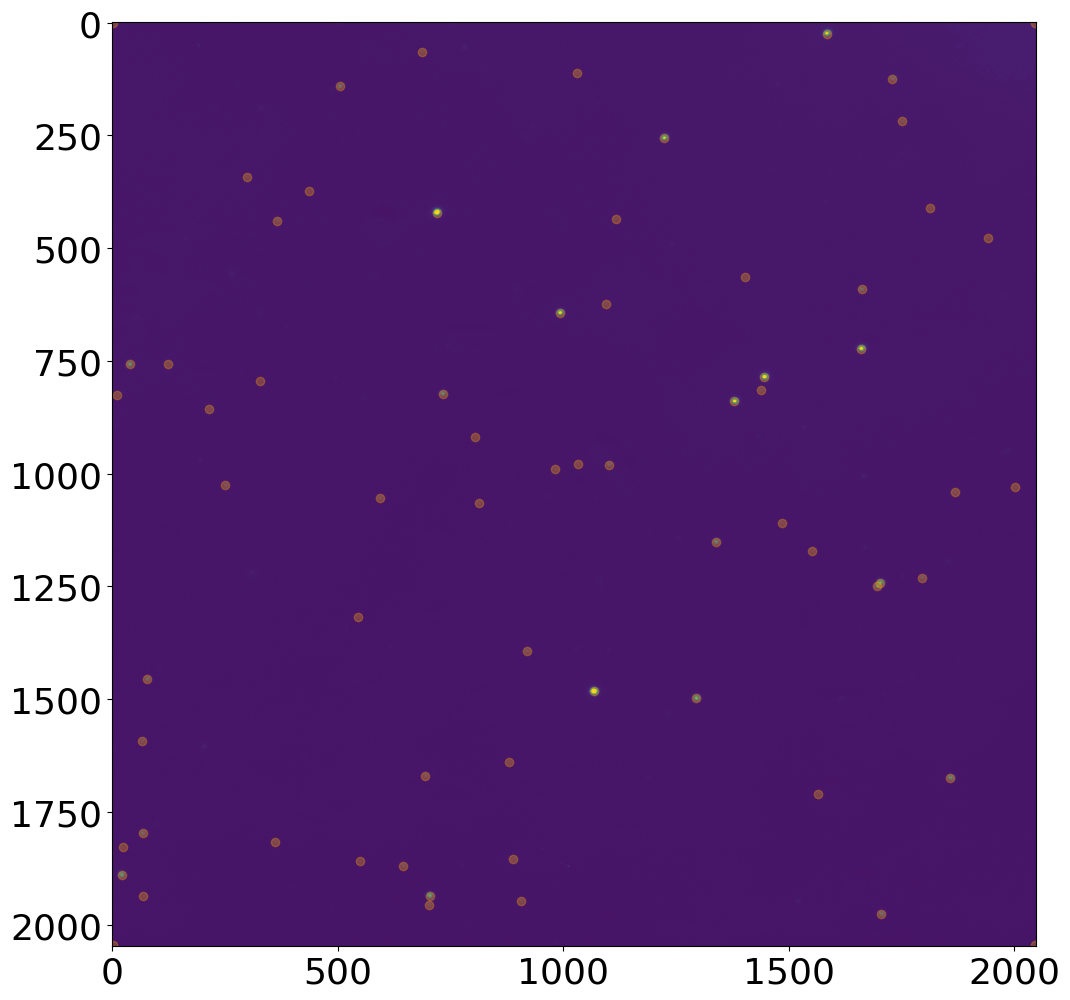

In [77]:
# Median absolute deviation

medAbsDev = mad_std(nnserIm)
daofind = DAOStarFinder(fwhm=6., threshold=5*medAbsDev)
sources = daofind(nnserIm)

# we can plot the x and y positions of sources to see if they are sensible
plt.imshow(nnserIm, vmax=20000)
plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.3, color="orange")

In [56]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2.1715022294029245,2.205757324788353,0.39650337069840036,0.185328094503308,0.017560550204620027,49,0.0,3584.5412639804713,15.216238559319667,-2.9557682712270337
2,2044.8347198867882,2.1956778811993707,0.4141219835749592,-0.1308845017896682,0.017226659049472303,49,0.0,3982.08946574234,16.519976225481642,-3.045023544938275
3,1583.8851395206882,24.411619109031395,0.40111489874792994,-0.20267944660249043,-0.5542798422684159,49,0.0,23361.32112900835,53.8760224279547,-4.3284888125904395
4,688.1432866526816,64.90866183079557,0.3387156282890054,-0.21984392821825519,-0.3901124140616212,49,0.0,4584.132175924579,3.118272108728618,-1.2347850254988146
5,1030.1672970524378,112.34617614411533,0.3314398297581236,-0.028604248931337815,-0.3880129866185154,49,0.0,4435.939964444962,2.252048838669438,-0.8814445113348739
6,1729.9129920310281,124.97600980922302,0.38326860761743897,-0.2093007664914188,-0.5800308778408642,49,0.0,7028.889067249705,9.460304514851648,-2.439762789997939
...,...,...,...,...,...,...,...,...,...,...
63,703.998322267598,1935.1642787058022,0.4092693792902371,0.0075209716934877225,-0.14768735456089557,49,0.0,14409.489804553587,26.776129343237088,-3.5693694930821063
64,69.2539799086722,1936.425145831809,0.5475192690881892,0.00938112658271039,-0.21243865814857696,49,0.0,4232.072879971068,1.6115141586421957,-0.5180853138594256


In [62]:
# x, y positions of the data in sources
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# Set up aperture and annulus
aperture = CircularAperture(positions, r=6.)
annulusAperture = CircularAnnulus(positions, r_in=10., r_out=15.)
apertures = [aperture, annulusAperture]

photoTable = aperture_photometry(nnserIm, apertures)
photoTable

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,,
int64,float64,float64,float64,float64
1,2.1715022294029245,2.205757324788353,242132.87521683765,455892.13026996417
2,2044.8347198867882,2.1956778811993707,263125.8352294489,495415.33523430733
3,1583.8851395206882,24.411619109031395,1498434.9545476092,1633150.7387228783
4,688.1432866526816,64.90866183079557,460490.6547491907,1436289.4219466308
5,1030.1672970524378,112.34617614411533,457825.4797406661,1444634.3418876026
6,1729.9129920310281,124.97600980922302,598478.0402518327,1497110.4891448119
...,...,...,...,...
64,69.2539799086722,1936.425145831809,438889.6778181741,1408969.2424661834


In [74]:
backgroundMean = photoTable['aperture_sum_1'] / annulusAperture.area

backgroundSum = backgroundMean * aperture.area
finalSum = photoTable['aperture_sum_1'] - backgroundSum

magnitudes = -2.5*np.log10(finalSum)
print(magnitudes)

   aperture_sum_1  
-------------------
-13.778355222494461
-13.868623598439736
 -15.16376566328573
-15.024304889027388
-15.030594820860749
 -15.06933461697245
-15.027407574541783
                ...
 -15.04490332977628
-15.003453765706887
-14.998109157912795
-15.038513545111037
 -15.02211283864514
 -13.75304649679451
 -13.75002846338784
Length = 69 rows


# Plotting Images

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 188.902051087  14.4947307031  
CRPIX : 1491.67533875  838.008033752  
CD1_1 CD1_2  : 8.46498479671e-05  -3.17061523672e-07  
CD2_1 CD2_2  : 3.28721564005e-07  8.47192772451e-05  
NAXIS : 2048  2048


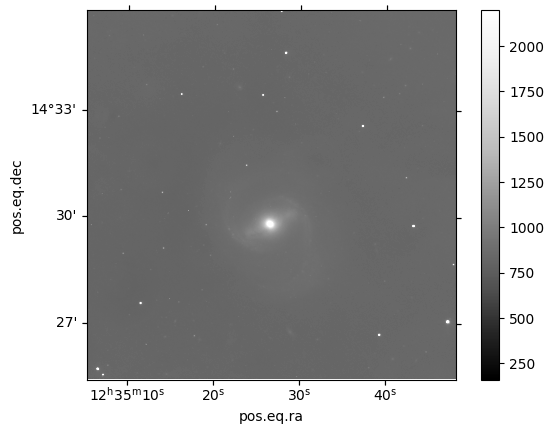

In [36]:
image = fits.open(rootPath + r"/output/positionedImage.fits")

# Read in world coordinate system from the file
wcs = WCS(image[0].header)
print(wcs)

# Now make a plot of the image, using this WCS information
plt.subplot(projection=wcs)
plt.imshow(image[0].data, cmap="Greys_r", vmin=160, vmax=2200)
plt.colorbar()